# Lab 8 – Distances and PCA

Name: Qixiao Zhu

Class: CSCI 349 - Intro to Data Mining  
Semester: Spring 2023
Due: Monday, Feb. 20
Instructor: Brian King


# Objectives
* Practice more `pandas`
* Use chi-squared test to evaluate two categorical variables for independence
* Learn about implementing distance matrices
* Learn how to employ PCA
* A bit more with visualizations

# Partnerships
I'm encouraging you to consider working with a partner. It's not required yet, but you are strongly encouraged to do so. If the material is complex to you, talking out what you are doing with a partner can have tremendous benefits. And, if you do, both partners must be listed in the top cell above.

# Directions
Work through this lab, and enter the answers to questions that are scattered throughout this lab. It is quite likely you'll need to add additional imports as you work through the lab. Just add them to the top cell if you use them. Most expected imports are added for you already.



In [760]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

---
**1)**	[P] Set up a pandas data frame with the following 8 observations and 3 variables.

```
   test1      test2  test3
A0     A  excellent     25
A1     C       fair     32
A2     C       good     60
A3     B       fair     53
A4     A       poor     23
A5     B  excellent     37
A6     C       good     45
A7     B       good     49
```

Be sure to set the types of each variable as follows:
* `test1`: Nominal, levels = { "A", "B", C" }
* `test2`: Ordinal, levels = { "poor", "fair", "good", "excellent" }
* `test3`: Numeric

Use `pd.Categorical` for the nominal and ordinal variables (and pay attention to the `ordered` parameter.) Name the data frame `df`. Set the `index` correctly to match the row names in the table above.

Display the `df` data frame, and then show the output of `df.info()` to show the type of each variable in `df`.

In [761]:
# ANSWER

df = pd.DataFrame(data={"test1": ["A", "C", "C", "B", "A", "B", "C", "B"],
                        "test2": ["excellent", "fair", "good", "fair", "poor", "excellent", "good", "good"],
                        "test3": [25, 32, 60, 53, 23, 37, 45, 49]},
                  index=["A0", "A1", "A2", "A3", "A4", "A5", "A6", "A7"])

df["test1"] = pd.Categorical(df["test1"], categories=["A", "B", "C"], ordered=False)
df["test2"] = pd.Categorical(df["test2"], categories=["poor", "fair", "good", "excellent"], ordered=True)
df

,test1,test2,test3
A0,A,excellent,25
A1,C,fair,32
A2,C,good,60
A3,B,fair,53
A4,A,poor,23
A5,B,excellent,37
A6,C,good,45
A7,B,good,49


In [762]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, A0 to A7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   test1   8 non-null      category
 1   test2   8 non-null      category
 2   test3   8 non-null      int64   
dtypes: category(2), int64(1)
memory usage: 480.0+ bytes


---
**2)**	[MP] Show the output of `df.describe(include='all')`. What does the `include='all'` parameter do?

In [763]:
# ANSWER

df.describe(include='all')

,test1,test2,test3
count,8,8,8.000000
unique,3,4,NaN
top,B,good,NaN
freq,3,3,NaN
mean,NaN,NaN,40.500000
std,NaN,NaN,13.416408
min,NaN,NaN,23.000000
25%,NaN,NaN,30.250000
50%,NaN,NaN,41.000000
75%,NaN,NaN,50.000000


**ANSWER:**

The parameter makes sure to describe all columns in the data frame, not only the numeric columns.

---
**3)**	[PM] Show the output of `df.test1.cat.categories`, and `df.test2.cat.categories`. What is this showing? Does it work for `df.test3.cat.categories`?

In [764]:
# ANSWER

df.test1.cat.categories

Index(['A', 'B', 'C'], dtype='object')

In [765]:
df.test2.cat.categories

Index(['poor', 'fair', 'good', 'excellent'], dtype='object')

**ANSWER:**

It does not work for test3 because the .cat accessor can only be used with categorical data

---
**4)**	[PM] Show the output of `df.test1.cat.codes`, and `df.test2.cat.codes`. What is this showing?

In [766]:
# ANSWER

df.test1.cat.codes

A0    0
A1    2
A2    2
A3    1
A4    0
A5    1
A6    2
A7    1
dtype: int8

In [767]:
df.test2.cat.codes

A0    3
A1    1
A2    2
A3    1
A4    0
A5    3
A6    2
A7    2
dtype: int8

**ANSWER:**

Pandas assigns one integer code for each category. This display the integer code for every observation.

---
**5)** [P] Report the counts of each level of the categorical variables.

In [768]:
# ANSWER

df["test1"].value_counts()

B    3
C    3
A    2
Name: test1, dtype: int64

In [769]:
df["test2"].value_counts()

good         3
fair         2
excellent    2
poor         1
Name: test2, dtype: int64

---
**6)** [P] Report a cross tabulation (i.e. contingency table) between `test1` and `test2`. Include the margins (i.e. the sum of the rows and the columns) in your reported table (HINT: Look up pandas `crosstab()` function).

Your results should look something like this:

```
test2  poor  fair  good  excellent  All
test1
A         1     0     0          1    2
B         0     1     1          1    3
C         0     1     2          0    3
All       1     2     3          2    8
```


In [770]:
# ANSWER

pd.crosstab(df["test1"], df["test2"], margins=True)

test2,poor,fair,good,excellent,All
test1,,,,,
A,1,0,0,1,2
B,0,1,1,1,3
C,0,1,2,0,3
All,1,2,3,2,8


---
**7)** [P] From the previous table, store the contingency table without the margins in a variable called `observed`

In [771]:
# ANSWER

observed = pd.crosstab(df["test1"], df["test2"])

---
**8)** [P] Run a chi-squared test for independence using the contingency table from the previous step. Clearly report the chi2 statistic, the p value, and the degrees of freedom, and then use the p-value to clearly state whether `test1` and `test2` are independent in your Python code (no markdown).

In [772]:
# ANSWER

chi2, pval, dof, expected = stats.chi2_contingency(observed)

print("chi2 statistic: " + str(chi2))
print("p value: " + str(pval))
print("degrees of freedom: " + str(dof))
print("The p value, " + str(pval) + ", is relatively large (larger than 0.05), "
                                    "so we fail to reject the null hypothesis "
                                    "because there is not enough evidence to "
                                    "prove that the two variables have dependency. ")

chi2 statistic: 6.444444444444444
p value: 0.37528525266160834
degrees of freedom: 6
The p value, 0.37528525266160834, is relatively large (larger than 0.05), so we fail to reject the null hypothesis because there is not enough evidence to prove that the two variables have dependency. 


---
Now, you're going to explore some similarities between observations. Yes, this is a SMALL dataset! (Don't bother to explore large data until you can understand how they work on small, toy experimental data!)

Before you can compute a pairwise distance matrix to report the distance between all pairs of observations, always remember that **you can only compute distances between strictly numeric data.** Therefore, you must convert your data to numeric types for ALL variables you want to include in your distance metric.

---
**9)** Create a new data frame called `df_num` that represents a numeric version of the above. Do NOT do any rescaling of your variables yet!

NOTE: If you do this from a dataframe that has the categorical variables set up properly, then this step is simple to do. The two choices I generally follow are either:

   1. use the cat member of your categorical data, which stores a `CategoricalAccessor` object (look it up), or
   2. use one of the encoders in the `sklearn.preprocessing` module.

The first option is easier, and yet another reason why it's so important to take the time to preprocess your data as correctly and error-free as possible.

If you do it correctly, your resulting dataframe should look something like this:
```
    test1  test2  test3
A0      0      3     25
A1      2      1     32
A2      2      2     60
A3      1      1     53
A4      0      0     23
A5      1      3     37
A6      2      2     45
A7      1      2     49
```

In [773]:
# ANSWER

df_num = df.copy(deep=True)
df_num["test1"] = df["test1"].cat.codes
df_num["test2"] = df["test2"].cat.codes

df_num

,test1,test2,test3
A0,0,3,25
A1,2,1,32
A2,2,2,60
A3,1,1,53
A4,0,0,23
A5,1,3,37
A6,2,2,45
A7,1,2,49


---
**10)** [P] As you learned in lecture, you absolutely must rescale your data to fall on a similar scale for most methods to be meaningful. There are different approaches to doing so. A standardized zscore is among the most common, but not necessarily always the best approach, especially when you are dealing with numeric representations of true categorical data. Rescaling your data to all fall between 0 and 1 is also a common approach, particularly when you have categorical data.

Let's first try to rescale our data to all fall between the values of 0 and 1. Use the `MinMaxScaler` in `sklearn.preprocessing` to rescale all variables to fall between 0 and 1. Store the transformed data as a pandas data frame called `df_num_zeroone`. Your result should look as follows:

```
    test1     test2     test3
A0    0.0  1.000000  0.054054
A1    1.0  0.333333  0.243243
A2    1.0  0.666667  1.000000
A3    0.5  0.333333  0.810811
A4    0.0  0.000000  0.000000
A5    0.5  1.000000  0.378378
A6    1.0  0.666667  0.594595
A7    0.5  0.666667  0.702703
```



In [774]:
# ANSWER

df_num_zeroone = pd.DataFrame(MinMaxScaler().fit_transform(df_num),
                              columns=df_num.columns,
                              index=df_num.index)
df_num_zeroone

,test1,test2,test3
A0,0.0,1.000000,0.054054
A1,1.0,0.333333,0.243243
A2,1.0,0.666667,1.000000
A3,0.5,0.333333,0.810811
A4,0.0,0.000000,0.000000
A5,0.5,1.000000,0.378378
A6,1.0,0.666667,0.594595
A7,0.5,0.666667,0.702703


---
**11)**	Notice the value of `test3`. It's OK, but there are times we have solid knowledge of what we expect our range to be. We can (and usually should) rescale our data using that knowledge. In the case of `test3`, suppose that you learned that the data must fall between 0 and 100.

Reassign `test3` so that the min and max before rescaling are assuming to be between 0 and 100, respectively. (i.e. simply divide the original variable by 100!)

In [775]:
# ANSWER
#
df_num_zeroone["test3"] = df_num["test3"] / 100

df_num_zeroone

,test1,test2,test3
A0,0.0,1.000000,0.25
A1,1.0,0.333333,0.32
A2,1.0,0.666667,0.60
A3,0.5,0.333333,0.53
A4,0.0,0.000000,0.23
A5,0.5,1.000000,0.37
A6,1.0,0.666667,0.45
A7,0.5,0.666667,0.49


---
**12)**	[P] Compute a single distance matrix called `distmat_zeroone`. Use a standard Euclidean distance measure. Your reported result should be an 8x8 matrix with appropriately labeled rows and columns. (HINT – study the output of the distance matrix functions. They do not output a square matrix. As discussed in lecture you can use either `pairwise_distances` from scikit-learn, or the `pdist` and `squareform` functions in `scipy.spatial.distance`). Be sure to label the rows and columns to be the index from the input dataframe. Round it to 3 significant digits.

Your result should look something like this...
```
       A0     A1     A2     A3     A4     A5     A6     A7
A0  0.000  1.204  1.111  0.879  1.000  0.514  1.073  0.647
A1  1.204  0.000  0.435  0.542  1.058  0.835  0.358  0.625
A2  1.111  0.435  0.000  0.605  1.258  0.643  0.150  0.512
A3  0.879  0.542  0.605  0.000  0.672  0.686  0.606  0.336
A4  1.000  1.058  1.258  0.672  0.000  1.127  1.222  0.873
A5  0.514  0.835  0.643  0.686  1.127  0.000  0.606  0.354
A6  1.073  0.358  0.150  0.606  1.222  0.606  0.000  0.502
A7  0.647  0.625  0.512  0.336  0.873  0.354  0.502  0.000
```

In [776]:
# ANSWER

distmat_zeroone = pairwise_distances(X=df_num_zeroone,
                                     metric="euclidean")
distmat_zeroone = pd.DataFrame(data=distmat_zeroone,
                               index=df_num_zeroone.index,
                               columns=df_num_zeroone.index).round(3)
distmat_zeroone

,A0,A1,A2,A3,A4,A5,A6,A7
A0,0.000,1.204,1.111,0.879,1.000,0.514,1.073,0.647
A1,1.204,0.000,0.435,0.542,1.058,0.835,0.358,0.625
A2,1.111,0.435,0.000,0.605,1.258,0.643,0.150,0.512
A3,0.879,0.542,0.605,0.000,0.672,0.686,0.606,0.336
A4,1.000,1.058,1.258,0.672,0.000,1.127,1.222,0.873
A5,0.514,0.835,0.643,0.686,1.127,0.000,0.606,0.354
A6,1.073,0.358,0.150,0.606,1.222,0.606,0.000,0.502
A7,0.647,0.625,0.512,0.336,0.873,0.354,0.502,0.000


---
**13)**	[P] Output the top three closest (i.e. most similar) pairs of observations. You MUST write Python code to report these results! Do not simply print out your distance matrix and tell me your answers! Consider that this may have been thousands of observations! Always generate reported answers in code!

For each pair, output the pair of observations from the original dataframe and the distance between them.

(HINT: I actaully found this easiest to do with the output of `pdist` with the `sorted` function.)

Your first closest pair output might have output that looks something like this:

```
Closest: # 0 : ['A2', 'A6'] dist=0.150
   test1 test2  test3
A2     C  good     60
A6     C  good     45
```


In [777]:
# ANSWER:

# ChatGPT:
from scipy.spatial.distance import pdist

sorted_distances_zeroone = sorted(pdist(df_num_zeroone))
for i in range(3):
    zero_row = distmat_zeroone[distmat_zeroone ==
                               sorted_distances_zeroone[i].round(3)].stack().index[0][0]
    zero_col = distmat_zeroone[distmat_zeroone ==
                               sorted_distances_zeroone[i].round(3)].stack().index[0][1]

    print("Closest: # " + str(i) + " ['" + zero_row + "', '"
          + zero_col + "'] dist="
          + str(sorted_distances_zeroone[i].round(3)))
    print(df.loc[[zero_row, zero_col], :])
    print("")

Closest: # 0 ['A2', 'A6'] dist=0.15
   test1 test2  test3
A2     C  good     60
A6     C  good     45

Closest: # 1 ['A3', 'A7'] dist=0.336
   test1 test2  test3
A3     B  fair     53
A7     B  good     49

Closest: # 2 ['A5', 'A7'] dist=0.354
   test1      test2  test3
A5     B  excellent     37
A7     B       good     49



---
**14)**	[P] Output the three observations that are *least similar*, with the two most distant observations output first. Again, for each pair, output the two observations, and the distance between them

In [778]:
# ANSWER

for i in range(1, 4):
    zero_row = distmat_zeroone[distmat_zeroone ==
                               sorted_distances_zeroone[-i].round(3)].stack().index[0][0]
    zero_col = distmat_zeroone[distmat_zeroone ==
                               sorted_distances_zeroone[-i].round(3)].stack().index[0][1]

    print("Farthest: # " + str(i-1) + " ['" + zero_row + "', '"
          + zero_col + "'] dist="
          + str(sorted_distances_zeroone[-i].round(3)))
    print(df.loc[[zero_row, zero_col], :])
    print("")

Farthest: # 0 ['A2', 'A4'] dist=1.258
   test1 test2  test3
A2     C  good     60
A4     A  poor     23

Farthest: # 1 ['A4', 'A6'] dist=1.222
   test1 test2  test3
A4     A  poor     23
A6     C  good     45

Farthest: # 2 ['A0', 'A1'] dist=1.204
   test1      test2  test3
A0     A  excellent     25
A1     C       fair     32



---
**15)**	[P] Create a new data frame, `df_num_binarized`, that stores a *binarized* version for `test1` and `test2`. The variable `test3` is already numeric, scaled to fall between 0 and 1 already. So, once you've created `df_num_binarized`, then copy the variable `test3` from `df_num_zeroone` to `df_num_binarized`.

(HINT: Remember, `pd.get_dummies` makes this quite easy to do, or you could use `OneHotEncoder` from `sklearn.preprocessing` and set `sparse=False, dtype=int`)

Your first row might look something like the following:
```
    test1_A  test1_B  test1_C  test2_poor  test2_fair  test2_good  test2_excellent  test3
A0        1        0        0           0           0           0                1   0.25
```


In [779]:
# ANSWER

df_num_binarized = pd.get_dummies(data=df.loc[:, "test1":"test2"], columns=["test1", "test2"])
df_num_binarized["test3"] = df_num_zeroone["test3"]
df_num_binarized

,test1_A,test1_B,test1_C,test2_poor,test2_fair,test2_good,test2_excellent,test3
A0,1,0,0,0,0,0,1,0.25
A1,0,0,1,0,1,0,0,0.32
A2,0,0,1,0,0,1,0,0.60
A3,0,1,0,0,1,0,0,0.53
A4,1,0,0,1,0,0,0,0.23
A5,0,1,0,0,0,0,1,0.37
A6,0,0,1,0,0,1,0,0.45
A7,0,1,0,0,0,1,0,0.49


---
**16)**	[P] Now, compute `distmat_binarized` by computing the distance matrix for the df_binarized.

In [780]:
# ANSWER

distmat_binarized = pairwise_distances(df_num_binarized,
                                       metric="euclidean").round(3)
distmat_binarized = pd.DataFrame(distmat_binarized,
                                 columns=df_num_binarized.index,
                                 index=df_num_binarized.index)
distmat_binarized

,A0,A1,A2,A3,A4,A5,A6,A7
A0,0.000,2.001,2.030,2.020,1.414,1.419,2.010,2.014
A1,2.001,0.000,1.442,1.430,2.002,2.001,1.420,2.007
A2,2.030,1.442,0.000,2.001,2.034,2.013,0.150,1.418
A3,2.020,1.430,2.001,0.000,2.022,1.423,2.002,1.415
A4,1.414,2.002,2.034,2.022,0.000,2.005,2.012,2.017
A5,1.419,2.001,2.013,1.423,2.005,0.000,2.002,1.419
A6,2.010,1.420,0.150,2.002,2.012,2.002,0.000,1.415
A7,2.014,2.007,1.418,1.415,2.017,1.419,1.415,0.000


---
**17)**	[P] Report the three closest pairs, and the three most distant pairs from distmat_binarized

In [781]:
# ANSWER

sorted_distances_bin = sorted(pdist(df_num_binarized))
for i in range(3):
    bin_row = distmat_binarized[distmat_binarized ==
                                sorted_distances_bin[i].round(3)].stack().index[0][0]
    bin_col = distmat_binarized[distmat_binarized ==
                                sorted_distances_bin[i].round(3)].stack().index[0][1]

    print("Closest: # " + str(i) + " ['" + bin_row + "', '"
          + bin_col + "'] dist="
          + str(sorted_distances_bin[i].round(3)))
    print(df.loc[[bin_row, bin_col], :])
    print("")

for i in range(1, 4):
    bin_row = distmat_binarized[distmat_binarized ==
                                sorted_distances_bin[-i].round(3)].stack().index[0][0]
    bin_col = distmat_binarized[distmat_binarized ==
                                sorted_distances_bin[-i].round(3)].stack().index[0][1]

    print("Farthest: # " + str(i-1) + " ['" + bin_row + "', '"
          + bin_col + "'] dist="
          + str(sorted_distances_bin[-i].round(3)))
    print(df.loc[[bin_row, bin_col], :])
    print("")

Closest: # 0 ['A2', 'A6'] dist=0.15
   test1 test2  test3
A2     C  good     60
A6     C  good     45

Closest: # 1 ['A0', 'A4'] dist=1.414
   test1      test2  test3
A0     A  excellent     25
A4     A       poor     23

Closest: # 2 ['A3', 'A7'] dist=1.415
   test1 test2  test3
A3     B  fair     53
A7     B  good     49

Farthest: # 0 ['A2', 'A4'] dist=2.034
   test1 test2  test3
A2     C  good     60
A4     A  poor     23

Farthest: # 1 ['A0', 'A2'] dist=2.03
   test1      test2  test3
A0     A  excellent     25
A2     C       good     60

Farthest: # 2 ['A3', 'A4'] dist=2.022
   test1 test2  test3
A3     B  fair     53
A4     A  poor     23



---
**18)**	[M] Take a moment and compare and contrast your results. Which method do you think have the better results? Why? Which variable do you think was the distinguishing player in affecting the different outcomes between both of the above approaches to transforming your data to numeric results? Summarize what would have been the best transformation to make for all three variables.

**ANSWER:**

The first method works better in my opinion, because we have ordinal data in our data set. The first method, using integer to represent the scores, is very effective, because scores are hierarchical. Higher scores are closer to higher scores. The second method does not think this way. By binarizing the data, the pair wise distance does not recognize the distance in each score, but it just checks if two observations are equal.
"test2" really affects the outcomes, because it is ordinal. We see that the first method it actually lists the closest "test2" observations, but the first method's second observation does not have close "test2" observations.
For the first variable we can use binarization, since we are asked to analyze it as just nominal data. The second variable is ordinal and needs to be turned into integer so that we know the distance between two test scores. The third is numeric, so we only need to scale it.

---
**19)**	[P] Load in your next dataset using the following:

`df_car_crashes = sns.load_dataset('car_crashes')`

The dataset is directly downloaded from:
[https://github.com/mwaskom/seaborn-data/blob/master/car_crashes.csv](https://github.com/mwaskom/seaborn-data/blob/master/car_crashes.csv)

So, your first step with any new dataset is to understand your data. What are the variables? What does each observation represent? Sometimes, it's easy to figure out. Just Google! And, sometimes we need to make the best guess regarding our variables. For now, don't worry too much about specifics. This is a very simplified, highly aggregated dataset from much more extensive stats drawn from the [Insurance Institute for Highway Safety](https://www.iihs.org/iihs/topics/t/general-statistics/fatalityfacts/state-by-state-overview) (NOTE - this might make a great repository for some project?)

In [782]:
# ANSWER

df_car_crashes = sns.load_dataset('car_crashes')
df_car_crashes.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses,abbrev
0,18.8,7.332,5.640,18.048,15.040,784.55,145.08,AL
1,18.1,7.421,4.525,16.290,17.014,1053.48,133.93,AK
2,18.6,6.510,5.208,15.624,17.856,899.47,110.35,AZ
3,22.4,4.032,5.824,21.056,21.280,827.34,142.39,AR
4,12.0,4.200,3.360,10.920,10.680,878.41,165.63,CA


---
**20)**	[P] Preprocess your data. Minimally, you should move the state code to become the index for the dataframe, and then drop that column from your dataframe.

In [783]:
# ANSWER

df_car_crashes = df_car_crashes.set_index("abbrev", drop=True)
df_car_crashes.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
abbrev,,,,,,,
AL,18.8,7.332,5.640,18.048,15.040,784.55,145.08
AK,18.1,7.421,4.525,16.290,17.014,1053.48,133.93
AZ,18.6,6.510,5.208,15.624,17.856,899.47,110.35
AR,22.4,4.032,5.824,21.056,21.280,827.34,142.39
CA,12.0,4.200,3.360,10.920,10.680,878.41,165.63


In [784]:
df_car_crashes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, AL to WY
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total           51 non-null     float64
 1   speeding        51 non-null     float64
 2   alcohol         51 non-null     float64
 3   not_distracted  51 non-null     float64
 4   no_previous     51 non-null     float64
 5   ins_premium     51 non-null     float64
 6   ins_losses      51 non-null     float64
dtypes: float64(7)
memory usage: 3.2+ KB


In [785]:
df_car_crashes \
    = df_car_crashes.loc[:, :].apply(lambda x: pd.to_numeric(x, downcast='float'))
df_car_crashes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, AL to WY
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total           51 non-null     float32
 1   speeding        51 non-null     float32
 2   alcohol         51 non-null     float32
 3   not_distracted  51 non-null     float32
 4   no_previous     51 non-null     float32
 5   ins_premium     51 non-null     float32
 6   ins_losses      51 non-null     float32
dtypes: float32(7)
memory usage: 1.8+ KB


---
**21)**	[P] Create a new dataframe called `df_car_crashes_zscore` that represents the zscore transformation for `df_car_crashes`. Again, show the first five rows.



In [786]:
# ANSWER

df_car_crashes_zscore = zscore(df_car_crashes)
df_car_crashes_zscore.head()

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
abbrev,,,,,,,
AL,0.737445,1.168148,0.439938,1.002301,0.277692,-0.580083,0.430513
AK,0.565935,1.212695,-0.211310,0.608532,0.807258,0.943258,-0.022901
AZ,0.688443,0.756709,0.187616,0.459357,1.033142,0.070875,-0.981779
AR,1.619498,-0.483613,0.547408,1.676052,1.951700,-0.337701,0.321125
CA,-0.928653,-0.399524,-0.891763,-0.594276,-0.891968,-0.048418,1.266177


---
**22)**	[P] Create a distance matrix called `distmat_cars` based on the `df_car_crashes_zscore`. Display the entire distance matrix (which will likely be simplified visually due to its size)

In [787]:
# ANSWER

distmat_cars = pairwise_distances(df_car_crashes_zscore)
distmat_cars = pd.DataFrame(distmat_cars, columns=df_car_crashes_zscore.index,
                            index=df_car_crashes_zscore.index)
distmat_cars

abbrev,AL,AK,AZ,AR,CA,CO,CT,DE,DC,FL,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
abbrev,,,,,,,,,,,,,,,,,,,,,
AL,0.000000,1.848559,1.875942,2.616265,3.450372,2.687192,4.022977,2.426744,6.627070,2.863217,...,2.272782,1.760396,1.768022,4.073530,2.984473,3.691474,4.099447,2.658679,3.882304,1.345666
AK,1.848559,0.000000,1.461454,2.961700,3.503615,2.674699,3.719860,1.305465,5.923340,2.014017,...,3.030764,2.612894,1.983290,3.820444,3.230915,3.939532,3.874398,2.759540,4.080096,1.794331
AZ,1.875942,1.461454,0.000000,2.592933,3.873069,2.690949,4.341409,2.322674,6.312294,2.471886,...,1.805917,2.413953,2.496229,3.638752,2.564600,3.910659,3.716797,3.094545,3.452450,1.165002
AR,2.616265,2.961700,2.592933,0.000000,4.773783,4.082043,5.511677,3.375631,7.648001,2.722795,...,2.756086,2.090210,2.858256,5.375719,4.012612,4.577666,5.500790,2.401244,5.215076,3.105415
CA,3.450372,3.503615,3.873069,4.773783,0.000000,1.382473,1.360401,2.801377,3.725441,3.294284,...,4.729624,2.984643,4.199246,2.525129,2.637784,1.211871,2.322342,5.589190,3.094339,3.392714
CO,2.687192,2.674699,2.690949,4.082043,1.382473,0.000000,2.171261,2.348937,4.294426,2.884757,...,3.599348,2.449727,3.623915,1.893114,1.579660,1.580230,1.824522,4.943274,2.114426,2.217198
CT,4.022977,3.719860,4.341409,5.511677,1.360401,2.171261,0.000000,2.792619,3.100788,3.490418,...,5.401468,3.816674,4.346224,3.070455,3.461110,2.371613,2.500124,5.938001,3.628320,3.899592
DE,2.426744,1.305465,2.322674,3.375631,2.801377,2.348937,2.792619,0.000000,5.106619,1.442845,...,3.827587,2.556844,2.171300,3.771261,3.324290,3.389056,3.571201,3.438088,4.037818,2.427114
DC,6.627070,5.923340,6.312294,7.648001,3.725441,4.294426,3.100788,5.106619,0.000000,5.343223,...,7.356392,6.230942,7.019399,3.805078,4.898792,3.999740,3.303523,8.418524,4.939871,6.196665


---
**23)**	[P] An interesting way to suggest outliers is to take a distance matrix, aggregate the mean over each row or column, then sort the output in order. Why would this work? Because an observation that is an outlier should have a relatively high mean distance to all other observations! Do this, and output the list in descending order. (HINT: DC should be your largest outlier, listed first.)

In [788]:
# ANSWER

distmat_cars.mean().sort_values(ascending=False)

abbrev
DC    5.265665
ND    5.257310
SC    5.214264
LA    4.767480
MT    4.759816
WV    4.512765
NJ    4.310802
MA    4.197514
MS    4.048306
AR    3.897634
MD    3.749940
MN    3.719807
OK    3.618059
HI    3.591754
SD    3.585247
TX    3.572109
NY    3.531806
CT    3.514075
WI    3.468777
ID    3.440898
PA    3.440610
UT    3.438145
RI    3.434056
WA    3.296993
FL    3.205449
VA    3.156358
OR    3.130498
CA    3.116880
ME    3.105252
NH    3.100905
IA    3.098436
AK    3.091304
MI    3.072811
NE    3.065207
AL    3.033362
DE    3.021971
AZ    2.999865
TN    2.965255
KY    2.964332
NM    2.914953
IN    2.841386
WY    2.839487
VT    2.820077
NC    2.777656
OH    2.746863
MO    2.734449
GA    2.726648
NV    2.627496
CO    2.617432
IL    2.602263
KS    2.573618
dtype: float32

----
**24)**	[M] From this analysis, which 3 states seem to be the outliers?

**ANSWER:**

DC, ND, and SC.

---
**25)**	[P] OK. Let's explore the data visually. First, using the original, unscaled data frame `df_car_crashes`, create a scatter plot of insurance premiums vs. insurance losses, with total number of accidents as the size of the point. Create a label near to every point representing the two letter state code.

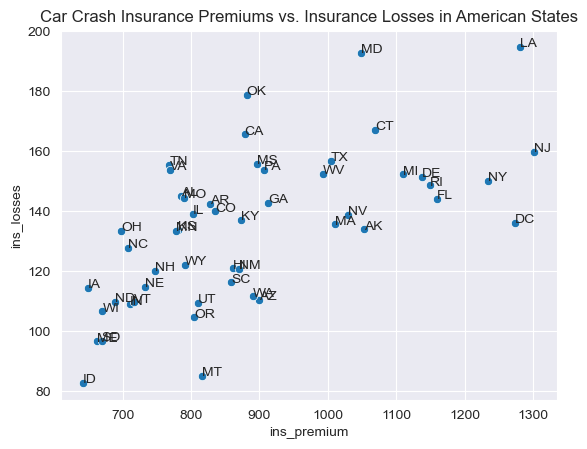

In [789]:
# ANSWER

sns.scatterplot(data=df_car_crashes, x=df_car_crashes["ins_premium"],
                y=df_car_crashes["ins_losses"])

plt.title("Car Crash Insurance Premiums vs. Insurance Losses in American States")
for i, label in enumerate(df_car_crashes.index):
    plt.text(df_car_crashes["ins_premium"][i], df_car_crashes["ins_losses"][i], label)
plt.show()

---
**26)** [P] Next, generate **two** plots that show some relationships between variables in the data. Try to use as many variables as you can without creating chaos! Don't just throw in multiple variables for the sake of showing them, only include them if it makes sense to do so. **Your aim is to derive meaning from your data. Good visualizations tell a story.** Strive to use at additional variables as size, as color, or even shape in your data so you can show more than just 2 variables on a single plot. Add titles, legends and label your axes as appropriate.

After each plot, create a markdown cell and briefly draw conclusions from your plot.

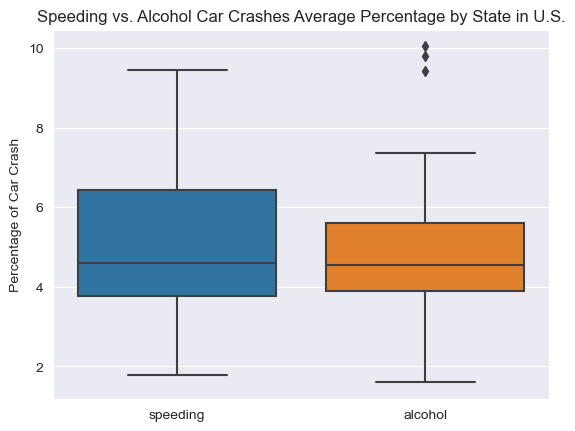

In [790]:
# ANSWER

sns.boxplot(data=df_car_crashes.loc[:, ["speeding", "alcohol"]])
plt.title("Speeding vs. Alcohol Car Crashes Average Percentage by State in U.S.")
plt.ylabel("Percentage of Car Crash")
plt.show()

**ANSWER:**

This graph compares the percentage of car crash by each state. We can see that the median value of the percentage of each state is approximately the same for speeding and alcohol, but speeding is more right skewed than alcohol. We can also see that percentage of crashes caused by speeding has more spread than percentage of crashes caused by alcohol. This means that percentage of crashes caused by speeding varies a lot among the states. The percentage of alcohol caused by speeding does not vary a lot among the states, the states combined are closer to the median of around 4.5. There are three outlier states for alcohol.

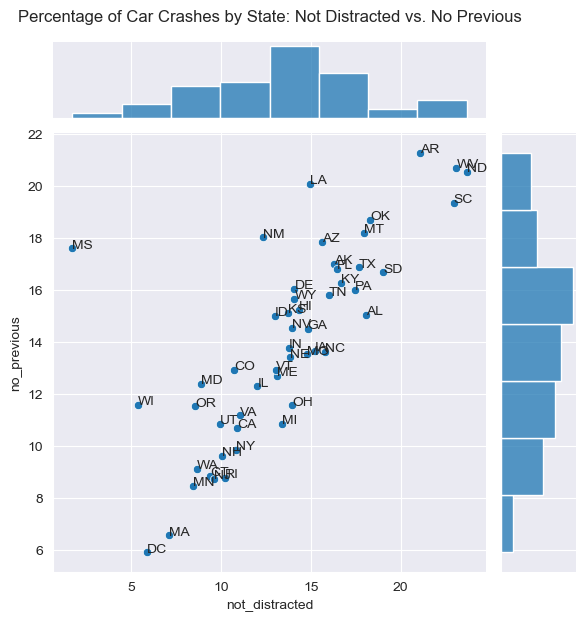

In [791]:
# ANSWER:

sns.jointplot(data=df_car_crashes, x=df_car_crashes["not_distracted"],
              y=df_car_crashes["no_previous"])
plt.title("Percentage of Car Crashes by State: Not Distracted vs. No Previous", pad=80)
for i, label in enumerate(df_car_crashes.index):
    plt.text(df_car_crashes["not_distracted"][i], df_car_crashes["no_previous"][i], label)
plt.show()

**ANSWER:**

This graph compares percentage of drivers who crashed that were not distracted and percentage of drivers who crashed with no previous incidents. We can see a cluster when not_distracted is at 14 and no_previous is at 16. A lot of the states fall here. States like AR, SC, and WV have a lot of the accidents happened when the drivers were either not distracted nor do not have previous incidents. DC on the other hand has most of the drivers crash while distracted and with previous incidents.


**27)**	 [P] Now, we're going to look at the data visually, but use a PCA transformation to help give a better sense of trends and differences among our data.

Run a full PCA on the zscore transformed data. Set `n_components` to be the number of variables in the original data. Be sure to fit the data to your PCA model, and then output the components, explained variance, and the explained variance ratio.

In [792]:
# ANSWER

# ChatGPT:
pca = PCA(n_components=df_car_crashes_zscore.shape[1])
pca.fit(df_car_crashes_zscore)
pca.components_

array([[ 0.4794708 ,  0.3753472 ,  0.45437634,  0.4380329 ,  0.45703417,
        -0.13083196, -0.0699605 ],
       [ 0.06893775,  0.07658448,  0.03345838,  0.0423748 ,  0.09612942,
         0.6852268 ,  0.7125246 ],
       [-0.26908788,  0.8182693 ,  0.08293253, -0.12616837, -0.31798822,
         0.25614268, -0.2617353 ],
       [ 0.03895593, -0.3637491 ,  0.14834374,  0.17126507,  0.0394817 ,
         0.65639603, -0.6183985 ],
       [ 0.1459764 , -0.02282806,  0.35479894, -0.85646844,  0.33610958,
         0.0421448 , -0.06327096],
       [-0.16970548, -0.22479218,  0.7837672 ,  0.08510587, -0.50401205,
        -0.11577346,  0.17805189],
       [ 0.8008251 ,  0.01784763, -0.15285765, -0.14247847, -0.55875385,
         0.04126616, -0.02804964]], dtype=float32)

In [793]:
pca.explained_variance_

array([4.094233  , 1.6095743 , 0.5616143 , 0.35753956, 0.28638542,
       0.20263323, 0.02802381], dtype=float32)

In [794]:
pca.explained_variance_ratio_

array([0.57342166, 0.22543044, 0.07865742, 0.05007554, 0.04010998,
       0.02837999, 0.0039249 ], dtype=float32)

---
**28)**	[M] Use your intuition – what do the weights of the first couple of PCs suggest explains most of the variance in the data? Are there certain variables that seem to be more significant? Or are they all playing a role?

**ANSWER:**

They suggest that the first five variables are strongly related to the variation in the data. The last two variables about insurance do not play a role in the percentage of car crashes in each state.

---
**29)** [P] Create a plot of the cumulative sum of the explained variance. How many components will get you to 90% of the explained variance?

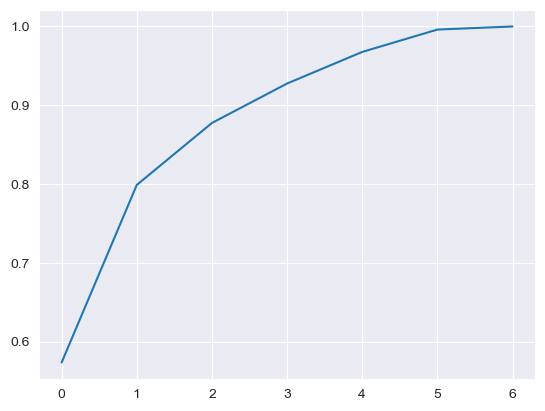

In [795]:
# ANSWER

# ChatGPT
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance_ratio)
plt.show()

# 2.5 components

---
**30)**	[P] Transform the z_score transformed data using your PCA model (HINT: use the `transform` function of the pca object.)

(NOTE: I often just store the transformed data temporarily as some arbitrary variable, X, to make it easier to manipulate the data for plotting and also use later.)

In [796]:
# ANSWER

X = pca.transform(df_car_crashes_zscore)
transformed_df = pd.DataFrame(data=X, index=df_car_crashes_zscore.index,
                              columns=df_car_crashes_zscore.columns)
transformed_df

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
abbrev,,,,,,,
AL,1.603671,0.133449,0.317881,-0.795293,-0.579718,0.046223,0.210185
AK,1.144212,0.858234,0.736627,0.318987,-0.228702,-1.002625,0.008966
AZ,1.432172,-0.420506,0.338137,0.552513,0.168717,-0.804523,-0.076108
AR,2.491584,0.348968,-1.788747,0.264064,-0.372383,-0.481849,-0.147636
CA,-1.750638,0.633625,-0.136176,-0.974916,-0.315811,0.178510,-0.068958
CO,-0.925120,-0.154388,0.146176,-0.568096,0.116420,-0.240859,-0.098428
CT,-2.125360,1.370601,0.743077,-0.485554,-0.088336,0.486531,0.020256
DE,0.324658,1.574245,0.440982,0.338057,0.095481,-0.466099,-0.188961
DC,-4.635926,0.918997,0.720078,1.184312,-0.172555,-0.052800,-0.124806


---
**31)**	[P] Generate a 2D plot using the first two principal components as your x and y coordinates. Be sure to label each point, and label your axes as component 1 and component 2, respectively.

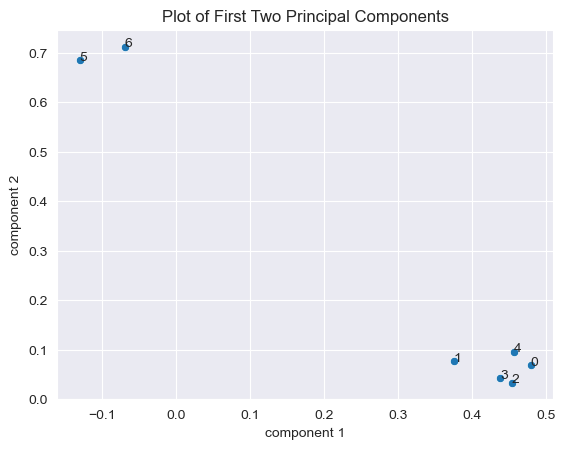

In [797]:
# ANSWER

com = pca.components_
df_com = pd.DataFrame(com[:2])
sns.scatterplot(data=df_com, x=df_com.loc[0, :], y=df_com.loc[1, :])
plt.title("Plot of First Two Principal Components")
plt.xlabel("component 1")
plt.ylabel("component 2")
for i in df_com.columns:
    plt.text(df_com.loc[0, i], df_com.loc[1, i], i)

plt.show()

---
**32)**	[M] Compare the states you reported as potential outliers above to those that appear to be outliers from your plot. Do the same results seem to hold?

**ANSWER:**

Yes, the same results hold. It seems like the outliers are still the last two variables.

---
**33)**	[P] Read how to generate a 3D scatterplot, and use it to generate a scatterplot of the first 3 components.

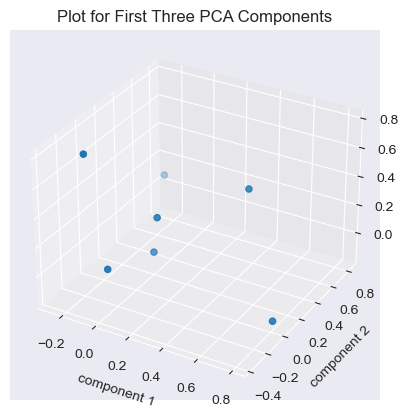

In [798]:
# ANSWER

# ChatGPT
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(com[:, 0], com[:, 1], com[:, 2])
ax.set_xlabel('component 1')
ax.set_ylabel('component 2')
ax.set_zlabel('component 3')
ax.set_title('Plot for First Three PCA Components')
plt.show()

---
**34)**	[M] Do the same outliers still stand out?

**ANSWER:**

Yes, the same outliers still stand out.